<a href="https://colab.research.google.com/github/jufabeck2202/KI-Lab/blob/main/Termin3_WS2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Matrixfaktorisierung

In [67]:
from scipy import sparse as sp
import pandas as pd
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt

In [68]:
TOP_MOVIES = 100
RANDOM_VIEWERS = 1000
reduced = np.load('netflix_reduced.npy')
headers = []
with open('netflix_headers.txt','r') as fi:
    for line in fi.readlines():
        headers.append(line.strip().split(',')[2])

In [69]:
DATASET = 1
VERBOSE = False #False
ITERATIONS = 100
def setup():
    global R,W,P,Q,ri,ci,k,m,n
    if DATASET == 0:
        R = [[5,4,0],
             [5,5,1],
             [1,0,5],
             [1,1,4]]
        R = np.array(R,dtype=np.float64)
        k=1
    elif DATASET == 1:
        R = reduced
        k = 10
    else:
        assert(False)

    W = R > 0
    m,n = R.shape
    R = (R-3)/2
    vecr = R[W]
    np.random.seed(42)
    P = np.random.rand(m,k)
    Q = np.random.rand(n,k)
def log(text):
    if VERBOSE:
        print(text)

# Einleitung

Sei $m$ die Anzahl der User und $n$ die Anzahl der Filme. Die Bewertungen der User für die Filme ist in zwei Matrizen $W$ und $R$ kodiert. $W \in \{0,1\}^{m \times n}$ ist eine Binärmaske, welche den Eintrag $1$ in einer Zeile $i$ und Spalte $j$ besitzt, falls der User mit dem Index $i$ eine Bewertung für den Film mit dem Index $j$ abgegeben hat. Der Eintrag ist $0$, falls dieser User diesen Film nicht bewertet hat. Sei $z$ die Anzahl der Einsen von $W$. 
Die Bewertungsmatrix $R \in [-1,1]^{m \times n}$ selbst beinhaltet die Bewertung des Films in Form einen Scores. Das Interval $[-1,1]$ wird als $[\text{gefällt nicht},\text{gefällt}]$ interpretiert. 

Existierende Filmbewertungen können Sie mit der plt.spy Funktion einsehen.

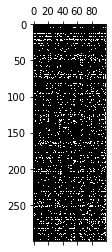

In [70]:
setup()
plt.spy(W)

Eine Auswahl an Filmen finden Sie hier:

In [102]:
#headers

Ziel der heutigen Aufgabe ist die Prädiktion der fehlenden Einträge in der Bewertungsmatrix $M$. Diese Prädiktionen könnten in einem Recommender-System genutzt werden, um einem User einer Platform einen Film vorzuschlagen.

Eine Möglichkeit bietet die Matrixfaktorisierung. Dabei wird versucht, zwei schlanke Faktoren $P \in \mathbb{R}^{m \times r}$ und $Q \in \mathbb{R}^{n \times k}$ zu finden mit $k \ll n$ und $k \ll m$, welche die Matrix $R$ so gut wie möglich rekonstruieren und zusätzlich neue Bewertungen prädizieren.
Implementieren Sie eine Funktion $f:\mathbb{R}^{m \times k} \times \mathbb{R}^{n \times k} \rightarrow \mathbb{R}^z$ mit

$f(P,Q) = (PQ^T - R)[W]$

wobei [W] hier als Indizierung zu verstehen ist. [W] extrahiert alle Residuen an den Stellen an denen $W$ den Eintrag $1$ hat. Alle $z$ Einträge werden Zeilenweise aufgesammelt und zu einem Vektor zusammengefasst. Anschließend können Sie die Kostenfunktion $e:f:\mathbb{R}^{m \times k} \times \mathbb{R}^{n \times k} \rightarrow \mathbb{R}$ berechnen durch

$e(P,Q) = \frac{1}{2}||f(P,Q)||_2^2 = \frac{1}{2}f^Tf$.

Die Funktion $f$ liefert sog. Residuen zurück, dh. sie beinhaltet die Abweichung der prädizierten Bewertungen von den tatsächlichen Berwertungen.

In [100]:
def f(_P,_Q):
    prod = _P.dot(_Q.T)
    difference = prod - R
    return difference[W]   

def e(_P,_Q):
    res1 = f(_P,_Q)
    result = res1.T.dot(res1)
    return result/2

e(P,Q)
print(P.dot(Q.T).shape)

(300, 100)


# Solver Implementierung
## ALS-Solver
Implementieren Sie den in der Vorlesung vorgestellten "alternating least-squares" (ALS)-Solver indem Sie $P$ und $Q$ alternierend anpassen um die Kosten $e$ zu minimieren. Die Parameter und Rückgabewerte der zu implementierenden Funktionen können Sie dem Funktionsaufruf weiter unten entnehmen.

In [114]:
#300 nutzer, 100 Filme, 2 verückte(beju, sito)
def solveBlockP(_P,_Q,user_idx):
    _Q = _Q.T
    print(f"p{_P.shape}")
    print(f"q{_Q.shape}")
    #q(100, 10)
    print(f"w{W.shape}")


    #Weclher utzter hat welche file bewerted
    #Sei m die Anzahl der User und n die Anzahl der Filme. Die Bewertungen der User für die Filme ist in zwei Matrizen W und R kodiert. 
    #=>W∈{0,1}m×n ist eine Binärmaske, welche den Eintrag 1 in einer Zeile i und Spalte j besitzt
    #=>w(300, 100)
    print(_Q.shape)
    print(range(len(_Q)))
    userQ = np.array(_Q.shape)
    for film in range(len(_Q)):
        print(len(_Q[film]))
        userQ[film] = _Q[film]*W[user_idx]

    print(userQ)

    

   
    faktor_for_user_T = faktor_for_user.reshape((-1,1))
    mul = faktor_for_user_T * faktor_for_user
    print(mul.shape)

    invMul = np.linalg.inv(mul)
    #multiplier = 1/multiplier
    #vect = _P[user_idx] * R[W][user_idx]

    return 1 # * vect

def solveBlockQ(_P,_Q,movie_idx):    
    #spalte mal zeile
    multiplier = np.dot(_Q[movie_idx], (_Q[movie_idx].T))
    multiplier = 1/multiplier
    userQ = np.array(_Qshape)
    vect = _Q[movie_idx] * R[W][movie_idx]

    return multiplier * vect

setup()
solveBlockP(P,Q,0)
#solveBlockQ(P,Q,0)


p(300, 10)
q(10, 100)
w(300, 100)
(10, 100)
range(0, 10)
100


ValueError: ignored

Testen Sie Ihre Implementierung und starten Sie den ALS-Solver.

In [ ]:
setup()
print(f"Error ALS before optimization: {e(P,Q)}")
for iteration in range(ITERATIONS):
    for user in range(m): 
        P[user] = solveBlockP(P,Q,user)
    log(f"Cost after update P: {e(P,Q)}")
    for movie in range(n):
        Q[movie] = solveBlockQ(P,Q,movie)
    log(f"Cost after update Q: {e(P,Q)}")
print(f"Error ALS after optimization: {e(P,Q)}")